#### Import dataset

In [60]:
import pandas as pd
from typing import List
import matplotlib.pyplot as plt

selected_params = ['wai', 'nai', 'prv', 'hpv', 'xf', 'alt', 'mn', 'tat', 'n1a', 'n2a', 'ff', 'egt', 'nf']

In [61]:
fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])

data = pd.concat([bgu, bdu]) \
  .drop(columns=['file_path', 'reason']) \
  .sort_values('reportts') \
  .reset_index() \
  .drop(columns=['index'])

# data = data[data['acnum'].isin(fleet)].dropna(subset=['egtm'])

#### Generate recursive features for n previous data points

In [62]:
def get_recursive_features(data: List[pd.DataFrame], features = [], n_back = 1):
  result = []
  for acdata in data:
    for pos in [1, 2]:
      df = acdata[acdata['pos'] == pos].copy().reset_index()
      X = df[features]
      X_aug = X.copy()
      for offset in range(1, n_back + 1):
        features_back = [f"{i}_{offset}" for i in features]
        X_aug.loc[0:offset, features_back] =  X.iloc[0,:].to_numpy()
        X_aug.loc[offset:, features_back] = X.iloc[:-offset,:].to_numpy()
      
      c = ['egtm', 'reportts', 'acnum', 'pos']
      X_aug.loc[:, c] = df[c]
      result.append(X_aug)
  
  result = pd.concat(result).sort_values('reportts') \
              .reset_index() \
              .drop(columns=['index'])
  return result

data = get_recursive_features([bgu, bdu], features=selected_params, n_back=1)

In [63]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_model(X, y):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]
  assert len(X_train) + len(X_test) == len(X)

  model = Ridge(alpha=0.2)

  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  # mse = mean_squared_error(y_train, predicted_train, squared=False)
  # mae = mean_absolute_error(y_train, predicted_train)
  # r2 = r2_score(y_train, predicted_train)

  predicted_test = model.predict(X_test)
  mse = mean_squared_error(y_test, predicted_test, squared=False)
  mae = mean_absolute_error(y_test, predicted_test)
  r2 = r2_score(y_test, predicted_test)

  return mse, mae, r2, model, predicted_train, predicted_test, train_i, y_test

In [64]:
X = data[selected_params]
y = data['egtm']

mse, mae, r2, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)
print(mse, mae, r2)

4.0657345994745935 3.242534244822903 -1.960708983948745


In [65]:
best_pred = (predicted_train.copy(), predicted_test.copy())
best_mse = mse
history = [mse]
pred_history = []

for i in range(1, 12): 
  data = get_recursive_features([bgu, bdu], features=selected_params, n_back=i)
  X = data.drop(columns=['egtm', 'acnum', 'pos', 'reportts'])
  y = data['egtm']
  mse, mae, r2, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)
  history.append(mse)
  if mse < best_mse:
    best_mse = mse
    best_pred = (predicted_train.copy(), predicted_test.copy())

  pred_history.append((predicted_train.copy(), predicted_test.copy()))
  
  print(f"{i} features back: rmse={mse:.3f} mae={mae:.3f} r2={r2:.3f}")
  print(f"Total features: {X.shape[1]}")
  print("Here: ", mean_absolute_error(y_test, predicted_test) == mae)


1 features back: rmse=3.222 mae=2.573 r2=-0.860
Total features: 26
Here:  True
2 features back: rmse=2.813 mae=2.219 r2=-0.418
Total features: 39
Here:  True
3 features back: rmse=2.570 mae=2.029 r2=-0.183
Total features: 52
Here:  True
4 features back: rmse=2.399 mae=1.903 r2=-0.031
Total features: 65
Here:  True
5 features back: rmse=2.275 mae=1.809 r2=0.073
Total features: 78
Here:  True
6 features back: rmse=2.187 mae=1.748 r2=0.144
Total features: 91
Here:  True
7 features back: rmse=2.123 mae=1.693 r2=0.193
Total features: 104
Here:  True
8 features back: rmse=2.047 mae=1.642 r2=0.249
Total features: 117
Here:  True
9 features back: rmse=1.982 mae=1.590 r2=0.297
Total features: 130
Here:  True
10 features back: rmse=1.921 mae=1.542 r2=0.339
Total features: 143
Here:  True
11 features back: rmse=1.867 mae=1.504 r2=0.376
Total features: 156
Here:  True


Text(0, 0.5, 'RMSE')

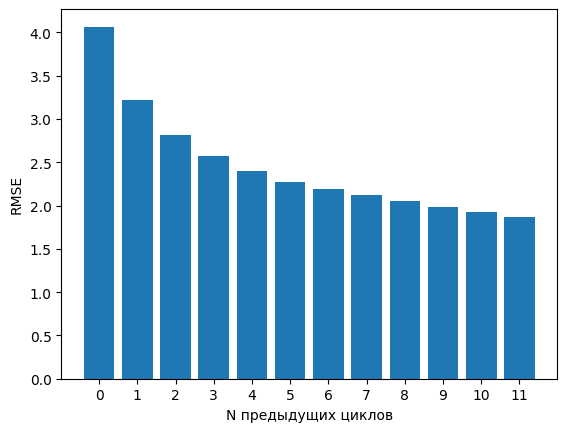

In [66]:
plt.bar(x=range(0, 12), height=history[:12])
plt.xticks(range(0, 12))
plt.xlabel("N предыдущих циклов")
plt.ylabel("RMSE")

In [67]:
import matplotlib.pyplot as plt

# Get exponential rolling average with smothing factor alpha
def smooth(x: pd.Series, alpha=0.5):
  return pd.Series(x).ewm(alpha=alpha, adjust=False).mean().to_list()

def plot_predictions(data, acnum, pos, train_i, predicted_test, predicted_train, is_smooth=True, figsize=(14, 7), title=None):
  data.loc[:train_i-1, 'pred_train'] = predicted_train
  data.loc[train_i:, 'pred_test'] = predicted_test

  sub = data[(data['acnum'] == acnum) & (data['pos'] == pos)]
  train_i2 = sub['pred_train'].count()

  plt.figure(figsize=figsize)

  if is_smooth:
    plt.plot(sub['reportts'][:train_i2], smooth(sub['pred_train'][:train_i2], alpha=0.3), '-')
    plt.plot(sub['reportts'], smooth(sub['pred_test'], alpha=0.3), '-')
  else:
    plt.scatter(sub['reportts'][:train_i2], sub['pred_train'][:train_i2], s=2)
    plt.scatter(sub['reportts'], sub['pred_test'], s=2)

  plt.plot(sub['reportts'], sub['egtm'], '-', color='#2ca02c')

  plt.title(f'Linear model of EGTM on {acnum} engine {pos}, Gas path params' if title is None else title)
  plt.legend(['train_pred', 'test_pred', 'true'])
  plt.show()

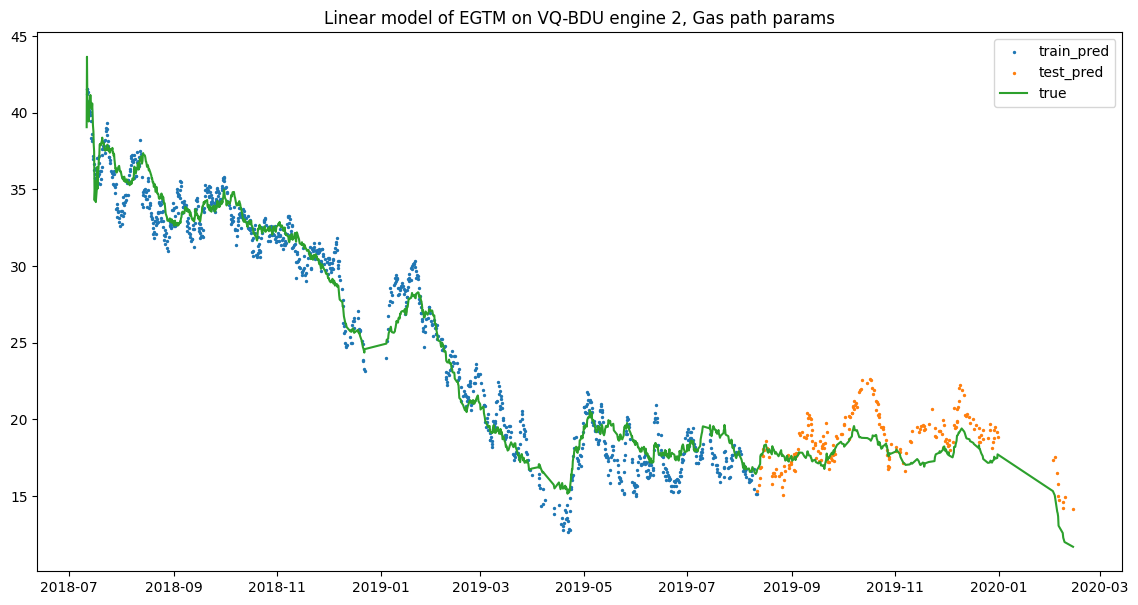

In [68]:

plot_predictions(data, 'VQ-BDU', 2, train_i, best_pred[1], best_pred[0], is_smooth=False)

In [ ]:
for (pred_train, pred_test) in pred_history:
  plot_predictions(data, 'VQ-BDU', 2, train_i, best_pred[1], best_pred[0], is_smooth=True, figsize=(6, 3))